<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter7/KNN_with_dynamic_DTW.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tsfresh "statsmodels<=0.12"

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Using cached tsfresh-0.21.0-py2.py3-none-any.whl.metadata (2.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 2.1 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [405 lines of output]
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
        Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.4 MB ? eta -:--:--
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.4 M

In [2]:
!pip install tslearn

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Option 1: Utiliser le style ancien format avec le préfixe v0_8
plt.style.use('seaborn-v0_8-whitegrid')

# OU Option 2: Utiliser directement le nouveau style Seaborn
# plt.style.use('seaborn')  # Style de base Seaborn

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"


In [7]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

In [8]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████| 66/66 [00:01<00:00, 36.65it/s]
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['T_y__partial_autocorrelation__lag_7'
 'T_y__partial_autocorrelation__lag_8'
 'T_y__partial_autocorrelation__lag_9' ...
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_x__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_x__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [9]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 223.53it/s]
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['T_y__partial_autocorrelation__lag_7'
 'T_y__partial_autocorrelation__lag_8'
 'T_y__partial_autocorrelation__lag_9' ...
 'F_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 5000.36it/s]


In [10]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f25012bea20>
Traceback (most recent call last):
  File "/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/envs/TimeSeries/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]})

In [16]:
def plot_cv_results(cv_results, metric, param_x, param_z=None):
    """
    Visualise les résultats de la recherche par grille avec validation croisée.

    Args:
        cv_results: Résultats de cv (de GridSearchCV.cv_results_)
        metric: Métrique d'évaluation utilisée (ex: 'accuracy', 'neg_mean_squared_error')
        param_x: Paramètre à afficher sur l'axe x
        param_z: Paramètre optionnel pour regrouper par couleur
    """
    # Construire les noms des colonnes correctement
    col_x = f'param_{param_x}'
    col_score = f'mean_test_score'  # La colonne de score est généralement 'mean_test_score'

    # Pour le tracé de base
    x_values = cv_results[col_x]
    scores = cv_results[col_score]

    # Création de la figure
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))

    if param_z is not None:
        # Si un paramètre z est fourni
        col_z = f'param_{param_z}'

        # Vérifier si la colonne existe
        if col_z not in cv_results:
            print(f"Attention: Le paramètre {param_z} n'existe pas dans cv_results. Affichage sans regroupement.")
            ax.plot(x_values, scores, 'o-', label=f'Score ({metric})')
        else:
            # Obtenir les valeurs uniques pour param_z
            z_values = cv_results[col_z].unique()

            # Palette de couleurs
            colors = plt.cm.tab10(np.linspace(0, 1, len(z_values)))

            # Tracer une ligne pour chaque valeur de param_z
            for i, z_val in enumerate(z_values):
                mask = cv_results[col_z] == z_val
                ax.plot(
                    cv_results[col_x][mask],
                    cv_results[col_score][mask],
                    'o-',
                    color=colors[i],
                    label=f'{param_z}={z_val}'
                )
    else:
        # Si aucun paramètre z n'est fourni, tracer simplement scores vs param_x
        ax.plot(x_values, scores, 'o-', label=f'Score ({metric})')

    # Ajout des titres et légendes
    ax.set_xlabel(param_x)
    ax.set_ylabel(f'Score ({metric})')
    ax.set_title(f'Résultats de validation croisée')
    ax.legend()
    ax.grid(True)

    return fig


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

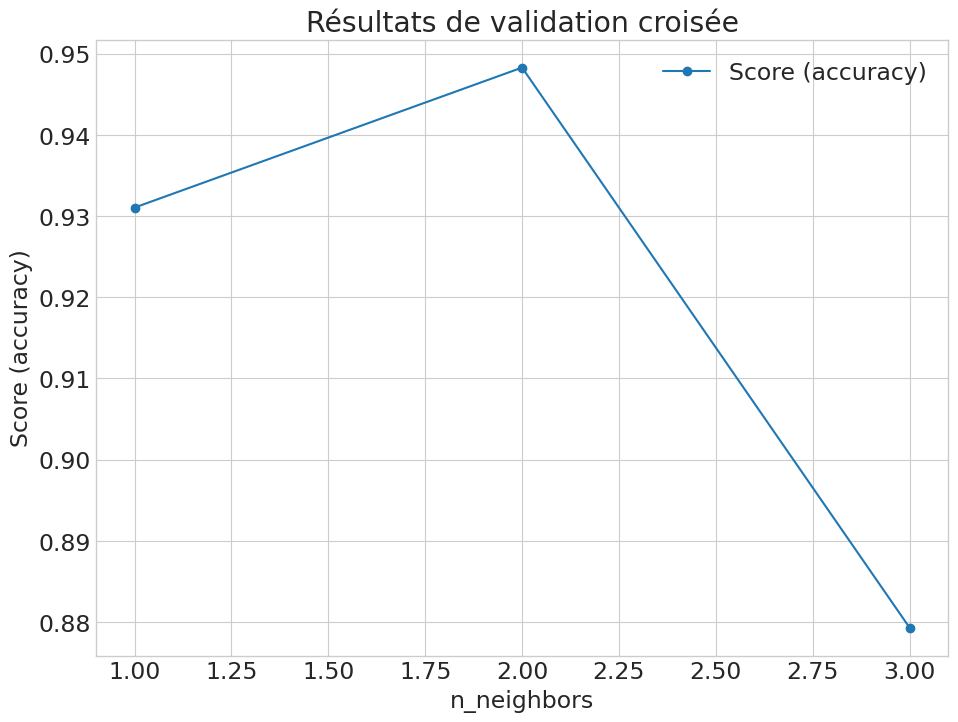

In [17]:
fig = plot_cv_results(gsearch.cv_results_, 'accuracy', 'n_neighbors')
